In [5]:
%%bash 
ls

Relax.ipynb
relax_data_science_challenge.pdf
takehome_user_engagement.csv
takehome_users.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Contents
1. Identify Active Users
2. Feature Engineering
3. Feature Selection

In [2]:
logins_df = pd.read_csv("takehome_user_engagement.csv",parse_dates = ["time_stamp"])
users_df = pd.read_csv("takehome_users.csv",
                       parse_dates = ["creation_time"],
                       encoding = 'latin-1')

users_df["last_session_creation_time"] = pd.to_datetime(users_df["last_session_creation_time"],unit='s')

In [3]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [4]:
users_df.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,0.432742,0.356432,124.056723,3383.761968
min,1.00000,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000


## Identify active users:
User has logged into the product on three separate days in at least one seven day period

In [5]:
# Set timestamps as index
logins_df.index = pd.to_datetime(logins_df.time_stamp, unit='s')
# drop viisted column since it is all ones and tells us nothing
logins_df.drop("visted",inplace=True)

In [7]:
def active_check(user_logins):
    #check if a user logged in at least 3 times
    if len(user_logins) > 2:
        #sort timestamps
        user_logins = user_logins.sort_values()
        
        # Compute timedeltas between logins
        login_deltas = [user_logins[i+1] - user_logins[i] for i in range(len(user_logins)-2)]
        
        # mark as active if sum of time deltas less than 7 days
        active_marker = [1 for i in range(len(login_deltas)-2) if \
                  login_deltas[i] + login_deltas[i+1] + login_deltas[i+2] <= datetime.timedelta(days=7)]
        if 1 in active_marker:
            return 1
        else:
            return 0
    else:
        return 0

In [8]:
resampled = logins_df.groupby("user_id").agg(active_check)
resampled.columns = ['active']
resampled.fillna(0,inplace=True)
resampled.head()

,active
user_id,
1,0
2,0
3,0
4,0
5,0


In [9]:
users_df = users_df.set_index("object_id").join(resampled,how="left")

## Feature Engineering
We can do some quick feature engineering and cleanup of this dataset and feed into a classification algorithm

In [10]:
# Check if user was invited by active user
invited_by_active = resampled.rename(columns={"active":"invited_by_active"})
users_df = users_df.set_index("invited_by_user_id").join(invited_by_active,how="left").reset_index(drop=True)

# Get size of each org
users_df['org_size'] = users_df['org_id'].map(users_df.groupby("org_id")["org_id"].count())

# Days since last login from 6/7/14
# Fill in missing logins with signup date
users_df.last_session_creation_time = users_df.last_session_creation_time.fillna(users_df.creation_time)

# Calculate time delta
users_df['days_since_login'] = \
    (datetime.date(year=2014,month=6,day=7) - users_df.last_session_creation_time).dt.days

users_df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,active,invited_by_active,org_size,days_since_login
0,2013-09-19 18:28:10,Vogt Yvonne,YvonneVogt@hotmail.com,ORG_INVITE,2013-09-20 18:28:10,0,0,94,0.0,0.0,32,259
1,2013-06-22 01:58:24,Azevedo Eduardo,emygkiip@bjtqb.com,GUEST_INVITE,2013-06-22 01:58:24,0,0,37,NaN,0.0,44,349
2,2013-12-16 04:15:12,Thomas Mitzi,odzovogp@eznoh.com,ORG_INVITE,2013-12-16 04:15:12,0,0,37,0.0,0.0,44,172
3,2014-02-26 14:42:34,Yabsley Cooper,CooperYabsley@gmail.com,ORG_INVITE,2014-02-28 14:42:34,1,1,37,0.0,0.0,44,98
4,2013-09-12 09:14:35,Oster Andrea,AndreaOster@gmail.com,ORG_INVITE,2013-09-12 09:14:35,0,0,37,0.0,0.0,44,267


In [11]:
# Check for null values
users_df.isna().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
active                        3177
invited_by_active             7276
org_size                         0
days_since_login                 0
dtype: int64

In [12]:
users_df.fillna(0,inplace=True)

In [13]:
# Drop unneeded columns: name, email, last
users_df = users_df[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','invited_by_active','org_size','days_since_login','active']]

users_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_active,org_size,days_since_login,active
0,ORG_INVITE,0,0,0.0,32,259,0.0
1,GUEST_INVITE,0,0,0.0,44,349,0.0
2,ORG_INVITE,0,0,0.0,44,172,0.0
3,ORG_INVITE,1,1,0.0,44,98,0.0
4,ORG_INVITE,0,0,0.0,44,267,0.0


## Feature Selection
1. Recursive Feature Elimination with Logistic Regression
2. Feature Importance through Random Forest

### RFE with Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [15]:
y = users_df['active']
X = users_df[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','invited_by_active','org_size','days_since_login']]
X = pd.get_dummies(X,columns=['creation_source'],drop_first=True)

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=.2)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [27]:
lgr = LogisticRegression(penalty="l1")
rfe = RFE(lgr, 5) #let's just keep the top 5 features
rfe = rfe.fit(X_train, y_train)

In [29]:
selected_features = rfe.support_ 
feature_ranking = rfe.ranking_ 

features = pd.DataFrame({'Selected Features': selected_features,
                         'Feature Rank': feature_ranking},
                         index=X.columns)


In [31]:
features.sort_values("Feature Rank")

,Feature Rank,Selected Features
enabled_for_marketing_drip,1,True
invited_by_active,1,True
creation_source_ORG_INVITE,1,True
creation_source_PERSONAL_PROJECTS,1,True
creation_source_SIGNUP,1,True
opted_in_to_mailing_list,2,False
creation_source_SIGNUP_GOOGLE_AUTH,3,False
days_since_login,4,False
org_size,5,False


Most important feature are ranked 1 through 5. This ranking intuitively makes sense.

### Random Forest Feature Importance
We can also fit a random forest algorithm and see which features are most important

In [33]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

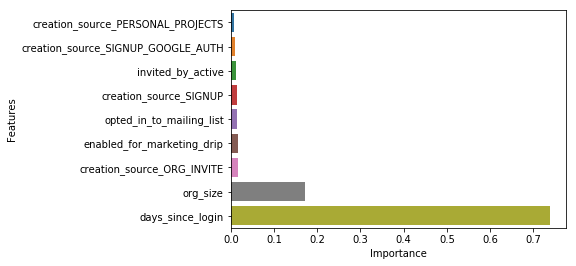

In [43]:
rfc.fit(X_train,y_train)
rfc_ranking = pd.DataFrame({"Features":X.columns,"Importance":rfc.feature_importances_})
rfc_ranking.sort_values("Importance",inplace=True)
sns.barplot(y="Features",x="Importance",data=rfc_ranking)
plt.show()

Interestingly, the random forest classifier ranks feature importance differently